# Project

In [1]:
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

## Sinan Bursa

In [2]:
credits = pd.read_csv('../../data/tmdb_5000_credits.csv')
credits = credits[credits.cast != '[]']


movies = pd.read_csv('../../data/tmdb_5000_movies.csv')
movies.drop(['homepage', 'keywords','original_language','overview','release_date','spoken_languages', \
             'status','title','tagline','vote_count'\
            ], \
            axis=1, \
            inplace=True \
           )

In [3]:
credits.drop(['title', 'crew'], axis=1, inplace=True)
credits['cast_id'] = credits['cast'].apply(lambda row: list(set(pd.read_json(row)['id'])))
#credits['cast_name'] = credits['cast'].apply(lambda row: list(set(pd.read_json(row)['name'])))
#credits['gender'] = credits['cast'].apply(lambda row: list(set(pd.read_json(row)['gender'])))

In [4]:
frames = pd.DataFrame()
new_df = pd.DataFrame()

for idx, film in credits.iterrows():
    cast_df = pd.DataFrame(eval(credits['cast'][idx]))
    cast_df['credits'] = idx
    cast_df = cast_df.drop(['character','order', 'credit_id', 'cast_id'],axis = 1)  
    
    frames = [new_df, cast_df]
    new_df = pd.concat(frames, join = 'outer', ignore_index=True)

In [5]:
discount_old = credits['cast_id'].apply(pd.Series).stack().value_counts()
discount_old = list(discount_old[discount_old > 4].index.astype(int))
#discount_old[:10]

In [6]:
nodes_df = new_df['credits'].groupby([new_df.gender, new_df.id, new_df.name]).apply(list).reset_index()
nodes_df = nodes_df[nodes_df['gender'].isin(['1','2'])]
discount_1 = nodes_df['id'].tolist()
discount = [x for x in discount_old if x in discount_1]
#nodes_df = nodes_df[nodes_df.id.isin(discount)]
#nodes_df.drop(columns=['credits'], inplace=True)
#nodes_df = nodes_df[nodes_df['gender'].isin(['1','2'])]

In [7]:
print('Old Values of the Discount')
print(discount_old[:10])
print(len(discount_old))
print('New Values of the Discount')
print(discount[:10])
print(len(discount))

Old Values of the Discount
[2231, 380, 62, 1892, 192, 884, 3896, 887, 85, 2963]
3766
New Values of the Discount
[2231, 380, 62, 1892, 192, 884, 3896, 887, 85, 2963]
3500


In [8]:
credits['cast_id'] = credits['cast_id'].apply(lambda x: [y for y in x if y in discount])
credits['edges'] = credits['cast_id'].apply(lambda x: list(itertools.combinations(x, 2)))
edges = list(credits['edges'].apply(pd.Series).stack())
edges[0:5]

edges_df = pd.DataFrame(edges)

In [9]:
edges_df.loc[edges_df[0] == 90596]

,0,1
174783,90596,18300


In [10]:
len(edges) #Our edges changed as we removed the gender 0's

185291

In [11]:
discarded_movies = set()

for idx, movie in credits.iterrows():
    if len(movie['edges']) == 0:
        discarded_movies.add(movie['movie_id'])

print(len(discarded_movies)) 

663


In [12]:
credits = credits[~credits['movie_id'].isin(discarded_movies)]
credits.head()

,movie_id,cast,cast_id,edges
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[30485, 98215, 42286, 68278, 65731, 42317, 109...","[(30485, 98215), (30485, 42286), (30485, 68278..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[2440, 2441, 2449, 2452, 1709, 1711, 1714, 171...","[(2440, 2441), (2440, 2449), (2440, 2452), (24..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[139549, 17064, 543530, 27319, 121529, 5309, 2...","[(139549, 17064), (139549, 543530), (139549, 2..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[21505, 53252, 77335, 535, 539, 1580574, 22075...","[(21505, 53252), (21505, 77335), (21505, 535),..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[17287, 17419, 2206, 2983, 5293, 21044, 57675,...","[(17287, 17419), (17287, 2206), (17287, 2983),..."


In [13]:
movies['profit'] = movies['revenue']-movies['budget']
movies_credits = movies.merge(credits, left_on='id', right_on='movie_id', how='inner').drop(columns=['movie_id'])

In [14]:
movies_credits = movies_credits[movies_credits.genres != '[]']
movies_credits['genre_id'] = movies_credits['genres'].apply(lambda row: list(pd.read_json(row)['id']))
movies_credits['genre_name'] = movies_credits['genres'].apply(lambda row: list(pd.read_json(row)['name']))

In [15]:
genre = movies_credits[['cast_id', 'genre_id', 'genre_name']]
genre.loc[:, 'genre_id_disc'] = genre['genre_id'].apply(lambda x: x[0])
genre.loc[:, 'genre_name_disc'] = genre['genre_name'].apply(lambda x: x[0])

/Users/SinanBursa/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/SinanBursa/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
genre_df = pd.DataFrame(genre.cast_id.tolist(), index=genre.genre_name_disc).stack().reset_index(name='cast_id')[['cast_id','genre_name_disc']]
most_freq_genre = genre_df.groupby(['cast_id']).agg(lambda x:x.value_counts().index[0])

In [17]:
profit_df = pd.DataFrame(movies_credits.cast_id.tolist(), index=movies_credits.profit).stack().reset_index(name='cast_id')[['cast_id','profit']]
profit_df['cast_id'] = profit_df.cast_id.astype(int)
profit_df = profit_df.groupby('cast_id', as_index=False).mean()
profit_df.set_index('cast_id', inplace=True)
profit_df.head()

,profit
cast_id,
3,1.596215e+08
4,1.594258e+08
6,5.387531e+08
7,4.952879e+08
10,6.340370e+08


In [18]:
profit_df = ((profit_df['profit']/(10**7)).round(0))*(10**7)
profit_df = profit_df.to_frame()

In [19]:
ranking_df = pd.DataFrame(movies_credits.cast_id.tolist(), index=movies_credits.vote_average).stack().reset_index(name='cast_id')[['cast_id','vote_average']]
ranking_df['cast_id'] = ranking_df.cast_id.astype(int)
ranking_df = ranking_df.groupby('cast_id', as_index=False).mean()
ranking_df.set_index('cast_id', inplace=True)
ranking_df.head()
     

,vote_average
cast_id,
3,6.634375
4,6.366667
6,7.437500
7,7.340000
10,7.466667


In [20]:
ranking_df = round(ranking_df['vote_average'] * 2) / 2
ranking_df = ranking_df.to_frame()

In [21]:
actors = ranking_df.merge(most_freq_genre, on='cast_id', how='inner')
actors = actors.merge(profit_df, on='cast_id', how='inner')

In [22]:
actors = actors.reset_index()
actors.head()

,cast_id,vote_average,genre_name_disc,profit
0,3,6.5,Adventure,160000000.0
1,4,6.5,Comedy,160000000.0
2,6,7.5,Adventure,540000000.0
3,7,7.5,Animation,500000000.0
4,10,7.5,Animation,630000000.0


In [23]:
#nodes_df = new_df['credits'].groupby([new_df.gender, new_df.id, new_df.name]).apply(list).reset_index()
nodes_df = nodes_df[nodes_df.id.isin(discount)]
nodes_df.drop(columns=['credits'], inplace=True)
#nodes_df = nodes_df[nodes_df['gender'].isin(['1','2'])]

In [24]:
actors = actors.merge(nodes_df, left_on = 'cast_id', right_on='id', how='inner').drop(columns=['cast_id'])

In [25]:
actors[actors['name']=='Leonardo DiCaprio']

,vote_average,genre_name_disc,profit,gender,id,name
824,7.0,Drama,220000000.0,2,6193,Leonardo DiCaprio


In [26]:
actors.sort_values(by='profit', ascending=False)

,vote_average,genre_name_disc,profit,gender,id,name
2396,6.5,Adventure,870000000.0,1,42286,Julene Renee
306,7.5,Adventure,760000000.0,2,1643,Adrian Rawlins
3411,7.5,Adventure,750000000.0,2,956224,Jamie Waylett
1218,7.5,Adventure,750000000.0,1,10991,Bonnie Wright
1253,7.5,Adventure,750000000.0,2,11212,Josh Herdman
3282,7.5,Adventure,750000000.0,2,140368,Oliver Phelps
3163,7.5,Adventure,750000000.0,2,96851,James Phelps
3162,7.5,Adventure,670000000.0,2,96841,Matthew Lewis
1992,8.0,Adventure,640000000.0,2,24343,Peter Mayhew
3372,7.5,Adventure,640000000.0,2,234922,Devon Murray


In [27]:
#features = nodes_df.set_index('id').drop('name', axis=1)
#features.head()

In [28]:
discount_df = pd.DataFrame(discount)
features = discount_df.merge(actors, left_on = 0, right_on='id', how='inner').drop(columns=[0])
features.head()

,vote_average,genre_name_disc,profit,gender,id,name
0,6.5,Action,160000000.0,2,2231,Samuel L. Jackson
1,6.5,Drama,50000000.0,2,380,Robert De Niro
2,6.0,Action,90000000.0,2,62,Bruce Willis
3,6.5,Drama,100000000.0,2,1892,Matt Damon
4,6.5,Action,140000000.0,2,192,Morgan Freeman


## Doing the Adjacency again
Cause we took out some genders and our size went from 3766 to 3500

In [29]:
len(edges)

185291

In [30]:
adj = pd.DataFrame(np.zeros(shape=(len(discount),len(discount))), columns=discount, index=discount)
for e1, e2 in edges:
    if e1 in discount and e2 in discount:
        adj.at[e1, e2] += 1
        adj.at[e2, e1] += 1
    else:
        edges.remove((e1,e2))

adj.head()

,2231,380,62,1892,192,884,3896,887,85,2963,...,59017,3272,15565,41746,59019,66288,3033,17187,51998,21318
2231,0.0,2.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
380,2.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
62,4.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,1.0,2.0,1.0,0.0,0.0,4.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
adjacency = adj.values
adj_max = adjacency.max()
adjacency = np.vectorize(lambda x: x/adj_max)(adjacency)

adjacency = pd.DataFrame(adjacency)

In [32]:
adjacency.head()

,0,1,2,3,4,5,6,7,8,9,...,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499
0,0.000000,0.166667,0.333333,0.000000,0.000000,0.166667,0.083333,0.000000,0.000000,0.166667,...,0.083333,0.0,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0
1,0.166667,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.250000,0.000000,0.000000,...,0.083333,0.0,0.0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.333333,0.083333,0.000000,0.083333,0.166667,0.166667,0.000000,0.166667,0.000000,0.083333,...,0.000000,0.0,0.0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.083333,0.166667,0.083333,0.000000,0.000000,0.333333,0.083333,0.083333,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [33]:
#IF WE NEED NON WEIGHTED ADJACENCY
adjacency_non_weighted = np.copy(adjacency)
adjacency_non_weighted[adjacency_non_weighted > 0] = 1
adjacency_non_weighted = np.asmatrix(adjacency_non_weighted)

In [34]:
graph = nx.from_numpy_array(adjacency_non_weighted)

In [35]:
node_props = features.to_dict()

In [36]:
for key in node_props:
    nx.set_node_attributes(graph, node_props[key], key)

In [37]:
graph.node[0]

{'vote_average': 6.5,
 'genre_name_disc': 'Action',
 'profit': 160000000.0,
 'gender': 2,
 'id': 2231,
 'name': 'Samuel L. Jackson'}

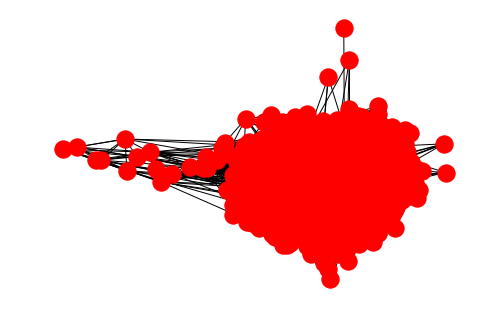

In [38]:
nx.draw_spring(graph)

In [39]:
nx.write_gexf(graph, 'CoAppAdjGephiFile.gexf')

In [40]:
adjacency.to_csv("CoAppAdjacency.csv")

In [41]:
features.to_csv("CoAppFeatures.csv")

In [42]:
edges_df.to_csv("CoAppEdges.csv")